<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression II

#### Learning Objectives
- **Define** data modeling and simple linear regression.
- **Build** a linear regression model using a data set that meets the linearity assumption using the scikit-learn library.
- **Understand** and identify multicollinearity in a multiple regression.
- **Practice** splitting features using dummification.
- **Know** when to apply regularization.

### Lesson Guide
- [Read in the  Capital Bikeshare Data](#read-in-the--capital-bikeshare-data)
- [What Is Multicollinearity?](#what-is-multicollinearity)
- [How to Select a Model](#how-to-select-a-model)
	- [Feature Selection](#feature-selection)
	- [Evaluation Metrics for Regression Problems](#evaluation-metrics-for-regression-problems)
	- [Comparing Models With Train/Test Split and RMSE](#comparing-models-with-traintest-split-and-rmse)
	- [Comparing Testing RMSE With Null RMSE](#comparing-testing-rmse-with-null-rmse)
- [Feature Engineering to Improve Performance](#feature-engineering-to-improve-performance)
	- [Handling Categorical Features](#handling-categorical-features)
	- [Feature Engineering](#feature-engineering)
- [Bonus Material: Regularization](#bonus-material-regularization)
	- [How Does Regularization Work?](#how-does-regularization-work)
	- [Lasso and Ridge Path Diagrams](#lasso-and-ridge-path-diagrams)
	- [Advice for Applying Regularization](#advice-for-applying-regularization)
	- [Ridge Regression](#ridge-regression)
- [Comparing Linear Regression With Other Models](#comparing-linear-regression-with-other-models)

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the Bikeshare Data Set
---

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge

%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

plt.style.use("fivethirtyeight")

<a id="read-in-the--capital-bikeshare-data"></a>
### Read In the Capital Bikeshare Data

In [12]:
# Read the data and set the datetime as the index.
url = 'data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)
bikes = bikes.rename(columns={'count': 'total_rentals'})

bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Dictionary
---

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1=winter, 2=spring, 3=summer, 4=fall |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| See Below|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

> _Details on Weather Variable_

> **1**: Clear, Few clouds, Partly cloudy, Partly cloudy

> **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

> **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

> **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

## LEARNING = REPRESENTATION + EVALUATION + OPTIMIZATION

Starting today, we'll be discussing many ways to make predictions using models. Often, newcomers think about the models as discrete things, e.g. "Linear Regression" or "Neural Network."

However, the models are all very closely related. In fact, all models can be understood using the following framework. 

Choose:
1. A fixed model.
    - Example: $\hat{y} = \beta_0 + \beta_1x_1.$
2. An evaluation technique.
    - Examples: MSE (Mean Squared Error), AUC (Area Under the Curve), etc.
3. An optimization technique (that solves for the parameters).
    - Examples: Exact linear algebra solution, gradient descent, etc.
 
> See [this classic paper](https://sites.astro.caltech.edu/~george/ay122/cacm12.pdf) -- "A Few Useful Things to Know About Machine Learning" by Pedro Domingos for more details.

<a id="what-is-multicollinearity"></a>
## What Is Multicollinearity?
---

Multicollinearity happens when two or more features are highly correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the variance inflation factor, which we will not cover here.

#### With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
AxesSubplot(0.08,0.07;0.696x0.81)


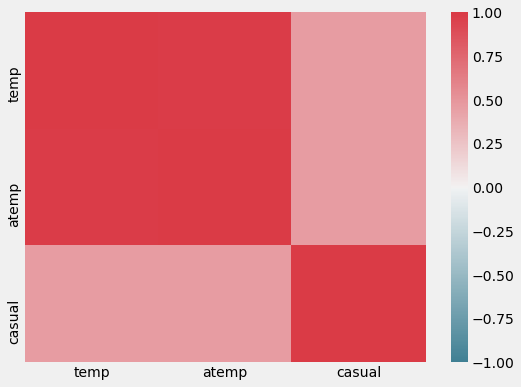

In [13]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'casual']].corr()

print(correlations)
print(sns.heatmap(correlations, cmap=cmap, vmin=-1))

#### Create a linear model that predicts `total_rentals` using `temp` and `atemp`.

In [14]:
# Create a list of features.
feature_cols = ['temp', 'atemp']

In [15]:
# Create X and y.
X = bikes[feature_cols]
y = bikes.total_rentals

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

4.248132645803736
[8.19865874 0.90720808]


### Reminder: Linear Regression Interpretation

This results in the model: $$\hat{\text{total_rentals}} = 4.2 + 8.2 \cdot \text{temp} + 0.91 \cdot \text{atemp}$$

Interpretation:
- When **temp** and **atemp** are 0 degrees Celcius, we predict 4.2 riders. 
- If **atemp** is held constant, then an increase of 1 degree **temp** is associated with an increase of 8.2 riders.
- If **temp** is held constant, then an increase of 1 degree **atemp** is associated with an increase of 0.91 riders.

#### Go back and remove either `temp` or `atemp` from the feature list. How do the coefficients change? 

In [16]:
# A:

<a id="how-to-select-a-model"></a>
## How to Select a Model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases. That said, it's important to keep the business context in mind and know that there are alternative metrics that can work better.

<a id="feature-selection"></a>
### Feature Selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use p-values or R-squared for feature selection?

- Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- If all of the assumptions of a linear model are met, p-values suggest a coefficient that differs from zero at a level of statistical significance. This does not mean that
    1. the feature _causes_ the response
    2. the feature strongly _predicts_ the response. 
- Adding features to your model that are unrelated to the response will always increase the R-squared value, and adjusted R-squared does not sufficiently account for this (although, AIC and BIC do).
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to directly estimate how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a machine learning methodology.
- This course focuses on general purpose approaches that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation Metrics for Regression Problems

Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems. We need evaluation metrics designed for comparing continuous values.

Here are three common evaluation metrics for regression problems:

**Mean absolute error (MAE)** is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean squared error (MSE)** is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root mean squared error (RMSE)** is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [17]:
# Example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and NumPy.

In [18]:
# Calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


In [19]:
# Same true values as above
true = [10, 7, 5, 5]
pred = [10, 7, 5, 13]

# MAE is the same as before.
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before.
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing Models With Train/Test Split and RMSE

In [20]:
from sklearn.model_selection import train_test_split

# Define a function that accepts a list of features and returns testing RMSE.
def train_test_rmse(df, feature_cols):
    X = df[feature_cols]
    y = df.total_rentals
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [21]:
# Compare different sets of features.
print(train_test_rmse(bikes, ['temp', 'season', 'weather', 'humidity']))
print(train_test_rmse(bikes, ['temp', 'season', 'weather']))
print(train_test_rmse(bikes, ['temp', 'season', 'humidity']))

155.64945913079674
164.1653997629182
155.59818936691417


In [22]:
# Using these as features is not allowed!
print(train_test_rmse(bikes, ['casual', 'registered']))

1.0315046973986794e-13


<a id="comparing-testing-rmse-with-null-rmse"></a>
### Always Compare Your Model to Other Models!

The simplest possible model is one that always predicts the same value, regardless of the inputs.

- What should our model predict to make it most accurate? Using MSE, it should always predict the mean!
- We call this the "Null Model."

In [23]:
# Can you compute the MSE of the null model?


In [24]:
# 

### What is R^2?

$R^2$ is a measure of **goodness of fit.** 

$$R^2 = 1 - \frac{\text{Var(model)}}{\text{Var(null model)}} = 1 - \frac{SSE_{\text{model}}}{SSE_{\text{null model}}}.$$

Some things to know about $R^2$:
1. $R^2$ is a value between 0 and 1 after fitting (0 = same fit as null model, 1 = perfect fit). If $R^2$ is less than one, the model performed worse than the null model.
2. $R^2$ compares your model to the null model. Since MSE *is* variance, it is often interpreted as "the amount of explained variance."
3. $R^2$ only indicates how well your model fits the training set. It does not indicate how it will perform on unseen data (for prediction).
4. $R^2$ is the square of the correlation coefficient (or multiple correlation coefficient).
5. A large $R^2$ does not mean the model is good. (See [Anascombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet).)

In [25]:
# Can you compute R^2? Does it match the `score` function?



<a id="feature-engineering-to-improve-performance"></a>
## Feature Engineering to Improve Performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
### Handling Categorical Features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** Transform them to sensible numeric values (example: small=1, medium=2, large=3) (**Not recommended!**)
- **Unordered categories:** Use dummy encoding (0/1). Here, each possible category would become a separate feature.

What are the categorical features in our data set?

- **Ordered categories:** `weather` (already encoded with sensible numeric values)
- **Unordered categories:** `season` (needs dummy encoding), `holiday` (already dummy encoded), `workingday` (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an ordered relationship. Instead, we create multiple dummy variables.

#### Create dummy variables using `get_dummies` from Pandas.

In [26]:
season_dummies = pd.get_dummies(bikes.season, prefix='season')

#### Inspect the `DataFrame` of `dummies`.

In [27]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need three dummy variables (not four), and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the baseline level.

This circles back to the concept multicollinearity, except instead of one feature being highly correlated to another, the information gained from three features is directly correlated to the fourth.

#### Drop the first column.

In [28]:
# Do that here!
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

#### Reinspect the `DataFrame` of `dummies`.

In [29]:
# Print five random rows.
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.

If that's confusing, think about why we only need one dummy variable for `holiday`, not two dummy variables (`holiday_yes` and `holiday_no`).

#### We now need to concatenate the two `DataFrames` together.

In [30]:
# Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns).
bikes_dummies = pd.concat([bikes, season_dummies], axis=1)

# Print 5 random rows.
bikes_dummies.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0,0,1


#### Rerun the linear regression with dummy variables included.

In [31]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

linreg = LinearRegression()
linreg.fit(X, y)

list(zip(feature_cols, linreg.coef_))

[('temp', 11.186405863575786),
 ('season_2', -3.3905430997179926),
 ('season_3', -41.73686071317081),
 ('season_4', 64.41596146824205),
 ('humidity', -2.819481636259649)]

In [32]:
v = pd.Series(['R', 'D', 'R', 'D', 'D', 'R', 'R'])

In [33]:
# is_democrat = v.map({'D': 1, 'R': 0})
is_democrat = np.where(v == 'D', 1, 0)

In [34]:
is_democrat

array([0, 1, 0, 1, 1, 0, 0])

In [35]:
letters = pd.Series(['A', 'B', 'C', 'D', 'C'])

In [36]:
np.where(letters == 'C', '_', letters)

array(['A', 'B', '_', 'D', '_'], dtype=object)

How do we interpret the season coefficients? They are measured against the baseline (spring):

- Holding all other features fixed, summer is associated with a rental decrease of 3.39 bikes compared to the spring.
- Holding all other features fixed, fall is associated with a rental decrease of 41.7 bikes compared to the spring.
- Holding all other features fixed, winter is associated with a rental increase of 64.4 bikes compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our interpretation of the coefficients.

In most situations, it is best to have the dummy that is your baseline be the category that has the largest representation.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [37]:
# Compare original season variable with dummy variables.
print(train_test_rmse(bikes_dummies, ['temp', 'season', 'humidity']))
print(train_test_rmse(bikes_dummies, ['temp', 'season_2', 'season_3', 'season_4', 'humidity']))

155.59818936691417
154.33394593635998


<a id="feature-engineering"></a>
### Feature Engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature.

In [38]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [39]:
bikes.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='datetime', length=10886)

#### Encode `hour` as a categorical feature.

In [40]:
hour_dummies = pd.get_dummies(bikes.index.hour, prefix='hour', drop_first=True)
hour_dummies.head()

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
bikes_dummies.reset_index().head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals,season_2,season_3,season_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0,0,0


Hello `code`

```
def f():
    return 0
```

In [42]:
bikes_full = pd.concat([bikes_dummies.reset_index(), hour_dummies], axis=1)

In [43]:
bikes_full.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
xvars = ['humidity', 'temp', 'weather', 'holiday', 'workingday', 'windspeed']
season_cols = ['season_2', 'season_3', 'season_4']
hour_cols = ['hour_' + str(n) for n in range(1, 24)]
# hour_cols = [f'hour_{n}' for n in range(1, 24)]

In [45]:
xvars = xvars + season_cols + hour_cols

In [46]:
X = bikes_full[xvars]
y = bikes.total_rentals

model = LinearRegression()
model.fit(X, y)

model.score(X, y)

0.629383659333148

In [47]:
train_test_rmse(bikes_full, xvars)

111.47069228384213

#### Generate a `daytime` variable based on hour of the day.

#### Test the root mean squared error of our various `hour` encodings.

<a id="bonus-material-regularization"></a>
## Bonus Material: Regularization
---

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimum model complexity, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they rarely reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [48]:
# Include dummy variables for season in the model.
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']

X = bikes_dummies[feature_cols]
y = bikes_dummies.total_rentals

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [62]:
# alpha=0 is equivalent to linear regression.
from sklearn.linear_model import Ridge, Lasso

# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)

# Fit the model.
ridgereg.fit(X_train, y_train)

# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67429349903927


In [63]:
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

[('temp', 8.537530902593627),
 ('atemp', 2.4548540987561593),
 ('season_2', -9.325429567786642),
 ('season_3', -40.67899619746589),
 ('season_4', 61.11748928364873),
 ('humidity', -2.8650448305441487)]

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [64]:
# Try alpha=0.1.
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.96098662565274


In [65]:
# Examine the coefficients.
list(zip(feature_cols, ridgereg.coef_))

[('temp', 5.257452659873028),
 ('atemp', 4.254523291538837),
 ('season_2', -0.17934556275266345),
 ('season_3', -21.483942605445648),
 ('season_4', 56.68220784186634),
 ('humidity', -2.6588377914640904)]

While the MSE barely improved, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficient has greatly decreased toward 0.

Fitting and using a Lasso Regression in scikit-learn is very similar.  

In addition to the typical [lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the ridge and lasso methods.

## How do they work?

Lasso and Ridge Regression can be best understood by realizing they are optimization problems that can be solved using Lagrange Multipliers.

- Under this interpretation, the minimum MSE is found, subject to the sum-of-normed-coefficients constraint (e.g. $|\beta_1| + |\beta_2| = 1$).
- We can graphically visualize this as follows:

![](./imgs/lasso.png)
![](./imgs/lasso2.png)

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing Linear Regression With Other Models

Advantages of linear regression:

- Simple to explain.
- Highly interpretable.
- Model training and prediction are fast.
- No tuning is required (excluding regularization).
- Features don't need scaling.
- Can perform well with a small number of observations.
- Well understood.

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response.
- Performance is (generally) not competitive with the best supervised learning methods due to high bias.
- Can't automatically learn feature interactions.